<a href="https://colab.research.google.com/github/balakrishnanvinchu/deep-reinforcement-learning/blob/main/MAB_Clinical_Trial_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### `---------------Mandatory Information to fill------------`

### Group ID: 144
### Group Members Name with Student ID:
1. Student 1
2. Student 2
3. Student 3
4. Bhartendu Kumar - 2024aa05279@wilp.bits-pilani.ac.in


`-------------------Write your remarks (if any) that you want should get consider at the time of evaluation---------------`

Remarks: ##We did this assignment collaboratively, like discussing in meeting the theoritical part and the implementation !

# Scenario

A pharmaceutical company is conducting clinical trials to evaluate the effectiveness of three antiretroviral drug combinations for treating HIV-positive patients. Due to the ethical and cost constraints of clinical trials, it is critical to identify the most effective treatment regimen using the least number of patients. Each treatment (or “arm”) can lead to different outcomes depending on patient responses. The effectiveness of each treatment is evaluated using a reward function derived from the improvement in patients’ immune system markers and survival status.



# Problem Definition

You are provided with a clinical dataset where each record corresponds to a patient, including the treatment they received and the resulting health outcomes. Your task is to simulate a clinical trial environment using various MAB strategies to sequentially recommend treatments and observe outcomes. The objective is to maximize the overall success rate across trials by identifying and favouring the most effective treatment.



# Dataset

You will be provided a dataset containing the following fields:

* ***Age (age)***: Patient's age in years at baseline.
* ***Weight (wtkg)***: Continuous feature representing weight in kilograms at baseline.
* ***Gender (gender)***: Binary indicator of gender (0 = Female, 1 = Male).
* ***CD4 Counts (cd40, cd420)***: Integer values representing CD4 counts at baseline and 20+/-5 weeks.
* ***Treatment Indicator (trt)***: Categorical feature indicating the type of treatment received (0 = ZDV only, 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only).
* ***Censoring Indicator (label)***: Binary indicator (1 = failure, 0 = censoring) denoting patient status.


***Link for accessing dataset:***
https://drive.google.com/file/d/1LYfIrJ4VEEGeyOsSt_qoLk7FaAv5Jfx-/view?usp=sharing


# Environment Setup

***Arms (Actions):*** The treatment types (trt)
* Arm 0: ZDV only
* Arm 1: ZDV + ddI
* Arm 2: ZDV + Zal
* Arm 3: ddI only


**Reward Function:**

Reward `r` is defined as:

`r = 1, if (label == 0) and (cd420 > cd40)`

`r = 0, otherwise`


  
This reward represents a successful treatment outcome as an increase in CD4 count and survival.

**Assumptions:**

*Number of Iterations:* Run the simulation for at least 1000 trials (iterations), with the option to extend the number of trials depending on the convergence behavior or observed reward trends. In each iteration, simulate one patient trial using one of the bandit policies.


# Requirements and Deliverables:
Implement the Multi-Arm Bandit Problem for the given above scenario for all the below mentioned policy methods.

### Initialize constants

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

# Constants

NUM_ITERATIONS = 1000  # Number of iterations for the simulation
NUM_ARMS = 4       # Number of treatment arms (0: ZDV only, 1: ZDV + ddI, 2: ZDV + Zal, 3: ddI only)

# Epsilon values for epsilon-greedy policy
EPSILONS = [0.1, 0.2, 0.5]

# UCB constant
C = 1  # Exploration parameter for UCB


# Load Dataset (0.5M)

First 5 rows of the dataset:
   age     wtkg  gender  cd40  cd420  trt  label
0   48  89.8128       0   422    477    2      0
1   61  49.4424       0   162    218    3      1
2   45  88.4520       1   326    274    3      0
3   47  85.2768       1   287    394    3      0
4   43  66.6792       1   504    353    0      0

Dataset shape: (2139, 7)

Dataset summary statistics:
               age         wtkg       gender         cd40        cd420  \
count  2139.000000  2139.000000  2139.000000  2139.000000  2139.000000   
mean     35.248247    75.125311     0.827957   350.501169   371.307153   
std       8.709026    13.263164     0.377506   118.573863   144.634909   
min      12.000000    31.000000     0.000000     0.000000    49.000000   
25%      29.000000    66.679200     1.000000   263.500000   269.000000   
50%      34.000000    74.390400     1.000000   340.000000   353.000000   
75%      40.000000    82.555200     1.000000   423.000000   460.000000   
max      70.000000   159.93936

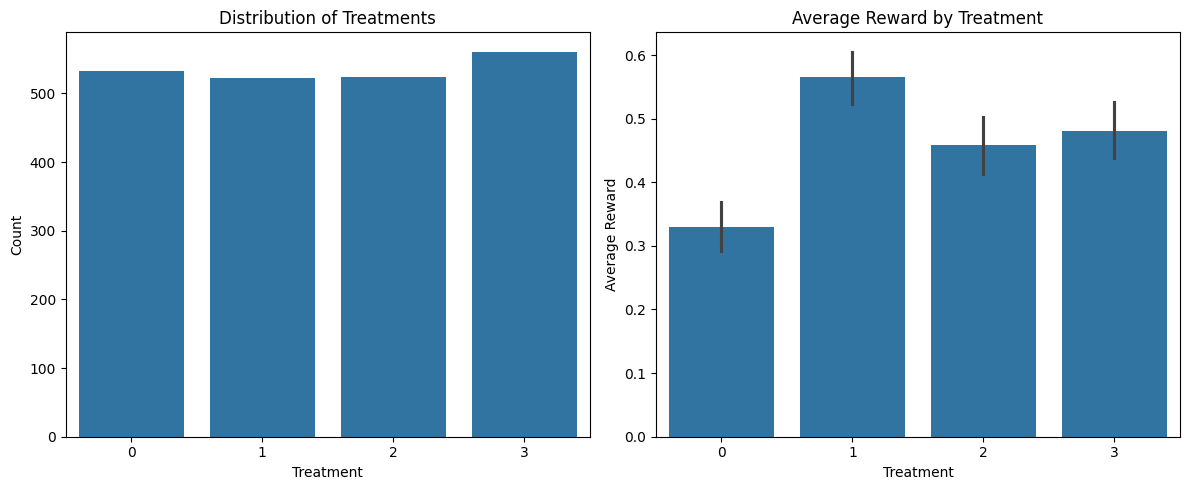

In [2]:
# Code for Dataset loading and print dataset statistics
#-----write your code below this line---------
# Load dataset
# Step 1: Load the clinical trial dataset from a public Google Drive link
url = "https://drive.google.com/uc?export=download&id=1LYfIrJ4VEEGeyOsSt_qoLk7FaAv5Jfx-"
df = pd.read_csv(url)

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Dataset statistics
print("\nDataset shape:", df.shape)
print("\nDataset summary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Distribution of treatments
print("\nTreatment distribution:")
print(df['trt'].value_counts())

# Distribution of outcomes
print("\nOutcome distribution:")
print(df['label'].value_counts())

# Calculate the reward based on the defined function
df['reward'] = ((df['label'] == 0) & (df['cd420'] > df['cd40'])).astype(int)

# Show reward distribution by treatment
print("\nAverage reward by treatment:")
print(df.groupby('trt')['reward'].mean())

# Create a matplotlib figure to visualize the distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='trt', data=df)
plt.title('Distribution of Treatments')
plt.xlabel('Treatment')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.barplot(x='trt', y='reward', data=df)
plt.title('Average Reward by Treatment')
plt.xlabel('Treatment')
plt.ylabel('Average Reward')

plt.tight_layout()
plt.show()

# Design a Clinical Trial Environment (0.5M)

In [3]:
# Code for environment setup along with reward function
class ClinicalTrialEnvironment:
    def __init__(self, data):
        """
        Initialize the clinical trial environment with the provided dataset

        Args:
            data (pandas.DataFrame): Dataset containing patient information and outcomes
        """
        self.data = data
        self.treatment_data = {}

        # Divide the dataset by treatment for easier sampling
        for trt in range(NUM_ARMS):
            self.treatment_data[trt] = self.data[self.data['trt'] == trt]

            # Check if there's enough data for each treatment
            if len(self.treatment_data[trt]) == 0:
                raise ValueError(f"No data available for treatment {trt}")

    def get_reward(self, action):
        """
        Get a reward by sampling a random patient who received the specified treatment

        Args:
            action (int): The treatment arm to select (0, 1, 2, or 3)

        Returns:
            int: Reward (1 for success, 0 for failure)
        """
        if action not in range(NUM_ARMS):
            raise ValueError(f"Invalid action: {action}. Must be one of {list(range(NUM_ARMS))}")

        # Sample a random patient who received this treatment
        sampled_patient = self.treatment_data[action].sample(1)

        # Calculate reward based on the defined reward function
        # r = 1, if (label == 0) and (cd420 > cd40)
        # r = 0, otherwise
        cd40 = sampled_patient['cd40'].values[0]
        cd420 = sampled_patient['cd420'].values[0]
        label = sampled_patient['label'].values[0]

        reward = 1 if (label == 0) and (cd420 > cd40) else 0
        return reward


# Using Random Policy (0.5M)
Implement a random policy for treatment selection and print each iteration. (Mandatory)

In [4]:
#  Run the environment with an agent that is guided by a random policy
import random

def random_policy(env, num_iterations):
    """
    Implements a random policy for treatment selection

    Args:
        env: The clinical trial environment
        num_iterations: Number of iterations to run

    Returns:
        rewards: List of rewards at each iteration
        actions: List of actions selected at each iteration
        cumulative_rewards: List of cumulative rewards at each iteration
    """
    rewards = []
    actions = []
    cumulative_rewards = []
    cumulative_reward = 0

    for i in range(num_iterations):
        # Select a random action
        action = random.randint(0, NUM_ARMS - 1)

        # Get reward
        reward = env.get_reward(action)

        # Update tracking variables
        rewards.append(reward)
        actions.append(action)
        cumulative_reward += reward
        cumulative_rewards.append(cumulative_reward)

        # Print progress periodically
        if (i + 1) % 100 == 0 or i == 0:
            print(f"Iteration {i+1}: Selected arm {action}, Reward: {reward}, Cumulative Reward: {cumulative_reward}")

    # Calculate the overall success rate
    success_rate = sum(rewards) / len(rewards)
    print(f"\nRandom Policy - Overall Success Rate: {success_rate:.4f}")

    # Count the number of times each arm was selected
    arm_counts = {arm: actions.count(arm) for arm in range(NUM_ARMS)}
    print(f"Arm selection counts: {arm_counts}")

    return rewards, actions, cumulative_rewards

# Initialize the environment
env = ClinicalTrialEnvironment(df)

# Run random policy
print("Running Random Policy...")
random_rewards, random_actions, random_cumulative_rewards = random_policy(env, NUM_ITERATIONS)

Running Random Policy...
Iteration 1: Selected arm 2, Reward: 0, Cumulative Reward: 0
Iteration 100: Selected arm 0, Reward: 1, Cumulative Reward: 56
Iteration 200: Selected arm 3, Reward: 0, Cumulative Reward: 101
Iteration 300: Selected arm 0, Reward: 0, Cumulative Reward: 142
Iteration 400: Selected arm 0, Reward: 1, Cumulative Reward: 189
Iteration 500: Selected arm 3, Reward: 0, Cumulative Reward: 231
Iteration 600: Selected arm 2, Reward: 1, Cumulative Reward: 270
Iteration 700: Selected arm 3, Reward: 1, Cumulative Reward: 316
Iteration 800: Selected arm 1, Reward: 1, Cumulative Reward: 360
Iteration 900: Selected arm 1, Reward: 0, Cumulative Reward: 405
Iteration 1000: Selected arm 1, Reward: 1, Cumulative Reward: 450

Random Policy - Overall Success Rate: 0.4500
Arm selection counts: {0: 256, 1: 250, 2: 227, 3: 267}


# Using Greedy Policy (1M)
Implement the Greedy policy that always selects the treatment with the highest average reward and print each iteration. (Mandatory)

In [5]:
#  Run the environment with an agent that is guided by a greedy policy

def greedy_policy(env, num_iterations):
    """
    Implements a greedy policy for treatment selection

    Args:
        env: The clinical trial environment
        num_iterations: Number of iterations to run

    Returns:
        rewards: List of rewards at each iteration
        actions: List of actions selected at each iteration
        cumulative_rewards: List of cumulative rewards at each iteration
    """
    rewards = []
    actions = []
    cumulative_rewards = []
    cumulative_reward = 0

    # Initialize values for each arm
    arm_rewards = [0] * NUM_ARMS
    arm_counts = [0] * NUM_ARMS

    # Initial exploration phase: try each arm once
    for arm in range(NUM_ARMS):
        reward = env.get_reward(arm)

        # Update tracking variables
        rewards.append(reward)
        actions.append(arm)
        cumulative_reward += reward
        cumulative_rewards.append(cumulative_reward)

        # Update arm statistics
        arm_rewards[arm] += reward
        arm_counts[arm] += 1

        print(f"Iteration {arm+1}: Selected arm {arm}, Reward: {reward}, Cumulative Reward: {cumulative_reward}")

    # Exploitation phase
    for i in range(NUM_ARMS, num_iterations):
        # Calculate average rewards for each arm
        avg_rewards = [arm_rewards[a] / arm_counts[a] if arm_counts[a] > 0 else 0 for a in range(NUM_ARMS)]

        # Select the arm with the highest average reward
        action = avg_rewards.index(max(avg_rewards))

        # Get reward
        reward = env.get_reward(action)

        # Update tracking variables
        rewards.append(reward)
        actions.append(action)
        cumulative_reward += reward
        cumulative_rewards.append(cumulative_reward)

        # Update arm statistics
        arm_rewards[action] += reward
        arm_counts[action] += 1

        # Print progress periodically
        if (i + 1) % 100 == 0 or i == NUM_ARMS:
            print(f"Iteration {i+1}: Selected arm {action}, Reward: {reward}, Cumulative Reward: {cumulative_reward}")

    # Calculate the overall success rate
    success_rate = sum(rewards) / len(rewards)
    print(f"\nGreedy Policy - Overall Success Rate: {success_rate:.4f}")

    # Show arm statistics
    print(f"Arm counts: {arm_counts}")
    avg_rewards = [arm_rewards[a] / arm_counts[a] if arm_counts[a] > 0 else 0 for a in range(NUM_ARMS)]
    print(f"Average rewards: {[round(r, 4) for r in avg_rewards]}")

    return rewards, actions, cumulative_rewards

# Run greedy policy
print("\nRunning Greedy Policy...")
greedy_rewards, greedy_actions, greedy_cumulative_rewards = greedy_policy(env, NUM_ITERATIONS)


Running Greedy Policy...
Iteration 1: Selected arm 0, Reward: 0, Cumulative Reward: 0
Iteration 2: Selected arm 1, Reward: 0, Cumulative Reward: 0
Iteration 3: Selected arm 2, Reward: 1, Cumulative Reward: 1
Iteration 4: Selected arm 3, Reward: 1, Cumulative Reward: 2
Iteration 5: Selected arm 2, Reward: 1, Cumulative Reward: 3
Iteration 100: Selected arm 3, Reward: 1, Cumulative Reward: 45
Iteration 200: Selected arm 3, Reward: 0, Cumulative Reward: 94
Iteration 300: Selected arm 3, Reward: 0, Cumulative Reward: 135
Iteration 400: Selected arm 3, Reward: 0, Cumulative Reward: 193
Iteration 500: Selected arm 3, Reward: 0, Cumulative Reward: 244
Iteration 600: Selected arm 3, Reward: 0, Cumulative Reward: 291
Iteration 700: Selected arm 3, Reward: 0, Cumulative Reward: 351
Iteration 800: Selected arm 3, Reward: 1, Cumulative Reward: 401
Iteration 900: Selected arm 3, Reward: 0, Cumulative Reward: 445
Iteration 1000: Selected arm 3, Reward: 1, Cumulative Reward: 491

Greedy Policy - Ove

# Using Epsilon-Greedy Policy (1.5M)
Implement the ε-Greedy policy with ε = 0.1, 0.2, 0.5. Report iteration-wise selections and rewards. Determine which ε yields the best result. (Mandatory)

In [6]:
#  Run the environment with an agent that is guided by an epsilon-greedy policy

def epsilon_greedy_policy(env, num_iterations, epsilon):
    """
    Implements an epsilon-greedy policy for treatment selection

    Args:
        env: The clinical trial environment
        num_iterations: Number of iterations to run
        epsilon: Probability of exploration

    Returns:
        rewards: List of rewards at each iteration
        actions: List of actions selected at each iteration
        cumulative_rewards: List of cumulative rewards at each iteration
    """
    rewards = []
    actions = []
    cumulative_rewards = []
    cumulative_reward = 0

    # Initialize values for each arm
    arm_rewards = [0] * NUM_ARMS
    arm_counts = [0] * NUM_ARMS

    for i in range(num_iterations):
        # Decide whether to explore or exploit
        if random.random() < epsilon:  # Explore
            action = random.randint(0, NUM_ARMS - 1)
        else:  # Exploit
            # Calculate average rewards for each arm
            avg_rewards = [arm_rewards[a] / arm_counts[a] if arm_counts[a] > 0 else 0 for a in range(NUM_ARMS)]

            # Select the arm with the highest average reward
            action = avg_rewards.index(max(avg_rewards))

        # Get reward
        reward = env.get_reward(action)

        # Update tracking variables
        rewards.append(reward)
        actions.append(action)
        cumulative_reward += reward
        cumulative_rewards.append(cumulative_reward)

        # Update arm statistics
        arm_rewards[action] += reward
        arm_counts[action] += 1

        # Print progress periodically
        if (i + 1) % 100 == 0 or i == 0:
            print(f"Iteration {i+1}: Selected arm {action}, Reward: {reward}, Cumulative Reward: {cumulative_reward}")

    # Calculate the overall success rate
    success_rate = sum(rewards) / len(rewards)
    print(f"\nEpsilon-Greedy Policy (ε={epsilon}) - Overall Success Rate: {success_rate:.4f}")

    # Show arm statistics
    print(f"Arm counts: {arm_counts}")
    avg_rewards = [arm_rewards[a] / arm_counts[a] if arm_counts[a] > 0 else 0 for a in range(NUM_ARMS)]
    print(f"Average rewards: {[round(r, 4) for r in avg_rewards]}")

    return rewards, actions, cumulative_rewards

# Store results for different epsilon values
epsilon_results = {}

# Run epsilon-greedy policy with different epsilon values
for epsilon in EPSILONS:
    print(f"\nRunning Epsilon-Greedy Policy with ε={epsilon}...")
    rewards, actions, cumulative_rewards = epsilon_greedy_policy(env, NUM_ITERATIONS, epsilon)
    epsilon_results[epsilon] = {
        'rewards': rewards,
        'actions': actions,
        'cumulative_rewards': cumulative_rewards
    }

# Determine which epsilon yields the best result
best_epsilon = max(EPSILONS, key=lambda e: sum(epsilon_results[e]['rewards']))
print(f"\nBest epsilon value: {best_epsilon} with total reward: {sum(epsilon_results[best_epsilon]['rewards'])}")


Running Epsilon-Greedy Policy with ε=0.1...
Iteration 1: Selected arm 0, Reward: 0, Cumulative Reward: 0
Iteration 100: Selected arm 1, Reward: 1, Cumulative Reward: 49
Iteration 200: Selected arm 1, Reward: 0, Cumulative Reward: 109
Iteration 300: Selected arm 3, Reward: 1, Cumulative Reward: 161
Iteration 400: Selected arm 1, Reward: 0, Cumulative Reward: 218
Iteration 500: Selected arm 1, Reward: 1, Cumulative Reward: 277
Iteration 600: Selected arm 1, Reward: 0, Cumulative Reward: 331
Iteration 700: Selected arm 1, Reward: 0, Cumulative Reward: 376
Iteration 800: Selected arm 1, Reward: 0, Cumulative Reward: 428
Iteration 900: Selected arm 1, Reward: 0, Cumulative Reward: 488
Iteration 1000: Selected arm 3, Reward: 1, Cumulative Reward: 557

Epsilon-Greedy Policy (ε=0.1) - Overall Success Rate: 0.5570
Arm counts: [40, 898, 26, 36]
Average rewards: [0.1, 0.5791, 0.5, 0.5556]

Running Epsilon-Greedy Policy with ε=0.2...
Iteration 1: Selected arm 0, Reward: 0, Cumulative Reward: 0
It

# Using UCB (1M)
Implement the UCB algorithm for treatment selection and print each  iteration. (Mandatory)

In [7]:
#  Run the environment with an agent that is guided by UCB
import math

def ucb_policy(env, num_iterations, c=2):
    """
    Implements Upper Confidence Bound (UCB) policy for treatment selection

    Args:
        env: The clinical trial environment
        num_iterations: Number of iterations to run
        c: Exploration parameter

    Returns:
        rewards: List of rewards at each iteration
        actions: List of actions selected at each iteration
        cumulative_rewards: List of cumulative rewards at each iteration
    """
    rewards = []
    actions = []
    cumulative_rewards = []
    cumulative_reward = 0

    # Initialize values for each arm
    arm_rewards = [0] * NUM_ARMS
    arm_counts = [0] * NUM_ARMS

    # Initial exploration phase: try each arm once
    for arm in range(NUM_ARMS):
        reward = env.get_reward(arm)

        # Update tracking variables
        rewards.append(reward)
        actions.append(arm)
        cumulative_reward += reward
        cumulative_rewards.append(cumulative_reward)

        # Update arm statistics
        arm_rewards[arm] += reward
        arm_counts[arm] += 1

        print(f"Iteration {arm+1}: Selected arm {arm}, Reward: {reward}, Cumulative Reward: {cumulative_reward}")

    # UCB selection phase
    for i in range(NUM_ARMS, num_iterations):
        ucb_values = []

        for arm in range(NUM_ARMS):
            # Calculate average reward for this arm
            avg_reward = arm_rewards[arm] / arm_counts[arm]

            # Calculate UCB value
            exploration_term = c * math.sqrt(math.log(i + 1) / arm_counts[arm])
            ucb_value = avg_reward + exploration_term
            ucb_values.append(ucb_value)

        # Select the arm with the highest UCB value
        action = ucb_values.index(max(ucb_values))

        # Get reward
        reward = env.get_reward(action)

        # Update tracking variables
        rewards.append(reward)
        actions.append(action)
        cumulative_reward += reward
        cumulative_rewards.append(cumulative_reward)

        # Update arm statistics
        arm_rewards[action] += reward
        arm_counts[action] += 1

        # Print progress periodically
        if (i + 1) % 100 == 0 or i == NUM_ARMS:
            print(f"Iteration {i+1}: Selected arm {action}, Reward: {reward}, Cumulative Reward: {cumulative_reward}")

    # Calculate the overall success rate
    success_rate = sum(rewards) / len(rewards)
    print(f"\nUCB Policy - Overall Success Rate: {success_rate:.4f}")

    # Show arm statistics
    print(f"Arm counts: {arm_counts}")
    avg_rewards = [arm_rewards[a] / arm_counts[a] if arm_counts[a] > 0 else 0 for a in range(NUM_ARMS)]
    print(f"Average rewards: {[round(r, 4) for r in avg_rewards]}")

    return rewards, actions, cumulative_rewards

# Run UCB policy
print("\nRunning UCB Policy...")
ucb_rewards, ucb_actions, ucb_cumulative_rewards = ucb_policy(env, NUM_ITERATIONS, C)


Running UCB Policy...
Iteration 1: Selected arm 0, Reward: 0, Cumulative Reward: 0
Iteration 2: Selected arm 1, Reward: 1, Cumulative Reward: 1
Iteration 3: Selected arm 2, Reward: 0, Cumulative Reward: 1
Iteration 4: Selected arm 3, Reward: 0, Cumulative Reward: 1
Iteration 5: Selected arm 1, Reward: 1, Cumulative Reward: 2
Iteration 100: Selected arm 2, Reward: 1, Cumulative Reward: 54
Iteration 200: Selected arm 3, Reward: 1, Cumulative Reward: 108
Iteration 300: Selected arm 3, Reward: 1, Cumulative Reward: 160
Iteration 400: Selected arm 2, Reward: 0, Cumulative Reward: 208
Iteration 500: Selected arm 2, Reward: 0, Cumulative Reward: 265
Iteration 600: Selected arm 1, Reward: 1, Cumulative Reward: 320
Iteration 700: Selected arm 3, Reward: 1, Cumulative Reward: 374
Iteration 800: Selected arm 1, Reward: 1, Cumulative Reward: 419
Iteration 900: Selected arm 1, Reward: 0, Cumulative Reward: 472
Iteration 1000: Selected arm 3, Reward: 1, Cumulative Reward: 523

UCB Policy - Overall 

# Plot the cumulative rewards for all policies on a single graph to compare their performance. (0.5M)

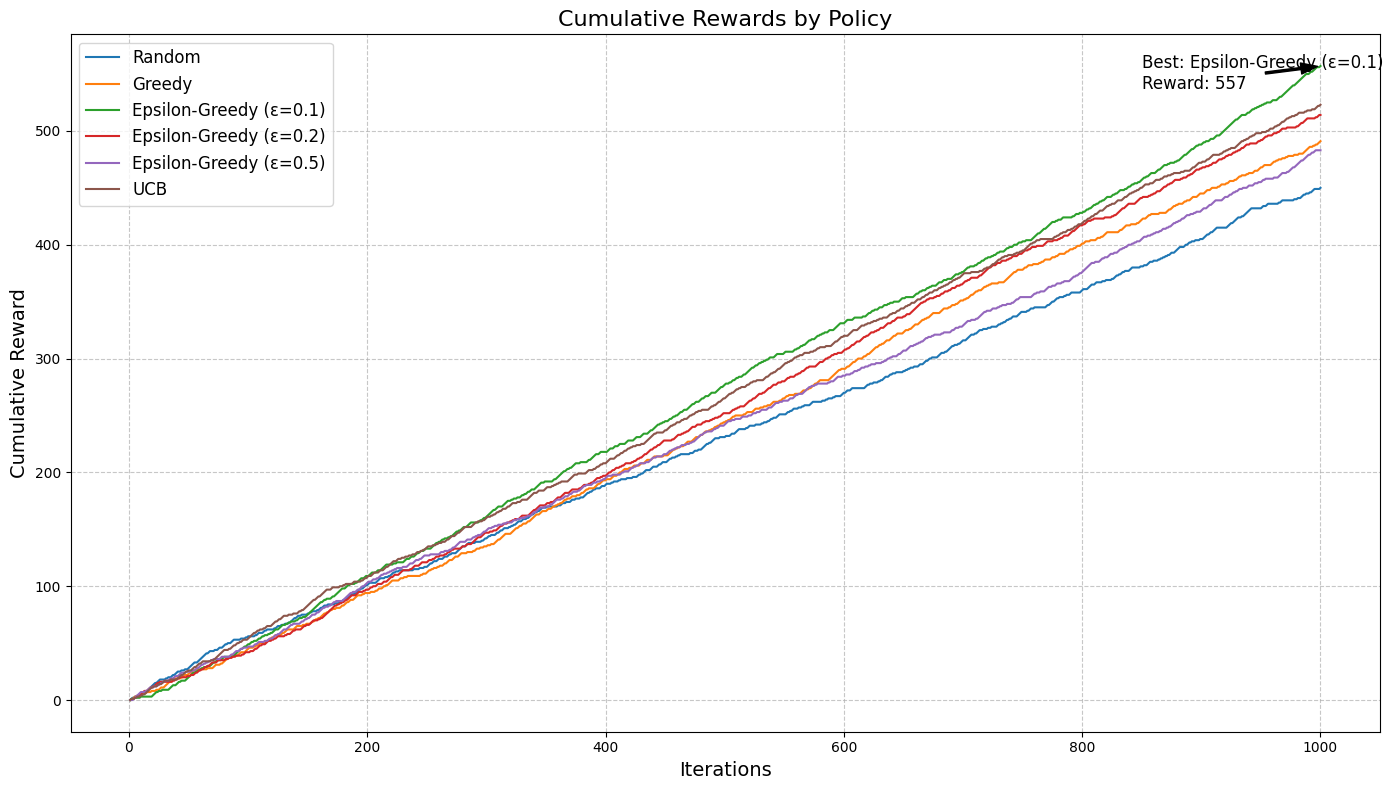

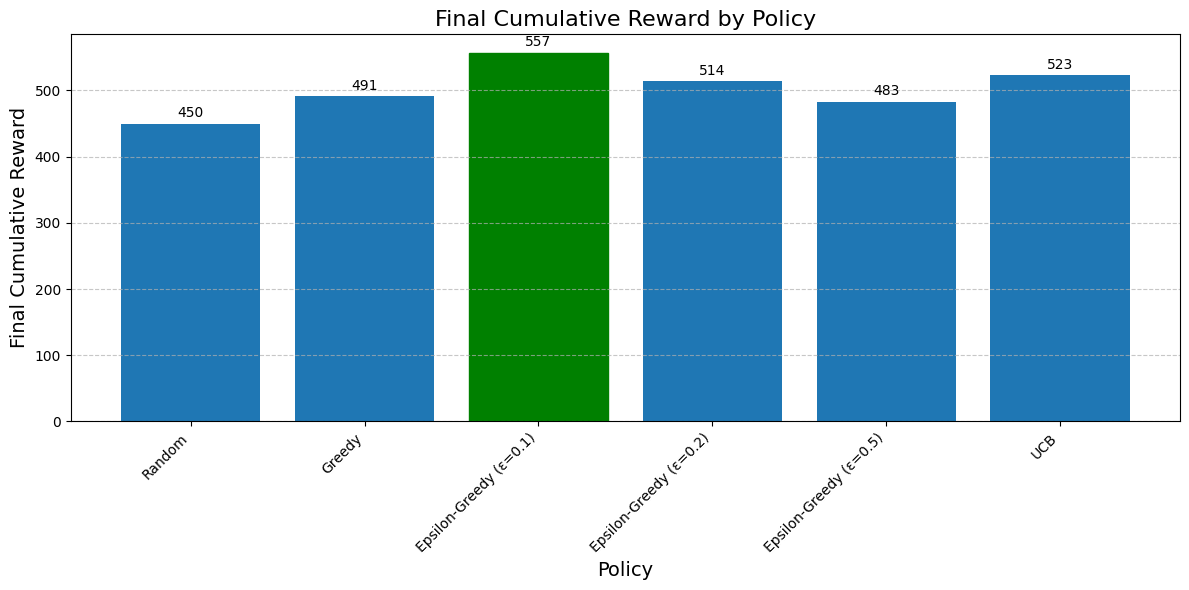


Policy Comparison:
------------------------------------------------------------
Policy                    Success Rate    Arm Selection Proportions               
------------------------------------------------------------
Random                    0.4500        Arm 0: 0.256, Arm 1: 0.250, Arm 2: 0.227, Arm 3: 0.267
Greedy                    0.4910        Arm 0: 0.001, Arm 1: 0.001, Arm 2: 0.008, Arm 3: 0.990
Epsilon-Greedy (ε=0.1)    0.5570        Arm 0: 0.040, Arm 1: 0.898, Arm 2: 0.026, Arm 3: 0.036
Epsilon-Greedy (ε=0.2)    0.5140        Arm 0: 0.048, Arm 1: 0.778, Arm 2: 0.095, Arm 3: 0.079
Epsilon-Greedy (ε=0.5)    0.4830        Arm 0: 0.141, Arm 1: 0.406, Arm 2: 0.129, Arm 3: 0.324
UCB                       0.5230        Arm 0: 0.035, Arm 1: 0.491, Arm 2: 0.271, Arm 3: 0.203
------------------------------------------------------------


In [8]:
#-----write your code below this line---------

# Plot the cumulative rewards for all policies
plt.figure(figsize=(14, 8))

# Plot random policy
plt.plot(range(1, NUM_ITERATIONS + 1), random_cumulative_rewards, label='Random')

# Plot greedy policy
plt.plot(range(1, NUM_ITERATIONS + 1), greedy_cumulative_rewards, label='Greedy')

# Plot epsilon-greedy policies
for epsilon in EPSILONS:
    plt.plot(range(1, NUM_ITERATIONS + 1), epsilon_results[epsilon]['cumulative_rewards'],
             label=f'Epsilon-Greedy (ε={epsilon})')

# Plot UCB policy
plt.plot(range(1, NUM_ITERATIONS + 1), ucb_cumulative_rewards, label='UCB')

# Add formatting
plt.title('Cumulative Rewards by Policy', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Cumulative Reward', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Add annotation for best performing policy
iteration_count = NUM_ITERATIONS
final_rewards = {
    'Random': random_cumulative_rewards[-1],
    'Greedy': greedy_cumulative_rewards[-1],
    **{f'Epsilon-Greedy (ε={epsilon})': epsilon_results[epsilon]['cumulative_rewards'][-1] for epsilon in EPSILONS},
    'UCB': ucb_cumulative_rewards[-1]
}
best_policy = max(final_rewards.items(), key=lambda x: x[1])

plt.annotate(f'Best: {best_policy[0]}\nReward: {best_policy[1]}',
             xy=(iteration_count, best_policy[1]),
             xytext=(iteration_count - 150, best_policy[1] - 20),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12)

plt.show()

# Additional comparison: Bar chart of final rewards
plt.figure(figsize=(12, 6))

policies = list(final_rewards.keys())
rewards = list(final_rewards.values())

bars = plt.bar(policies, rewards)

# Highlight the best performing policy
best_idx = rewards.index(max(rewards))
bars[best_idx].set_color('green')

plt.title('Final Cumulative Reward by Policy', fontsize=16)
plt.xlabel('Policy', fontsize=14)
plt.ylabel('Final Cumulative Reward', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate success rates for comparison
success_rates = {
    'Random': sum(random_rewards) / NUM_ITERATIONS,
    'Greedy': sum(greedy_rewards) / NUM_ITERATIONS,
    **{f'Epsilon-Greedy (ε={epsilon})': sum(epsilon_results[epsilon]['rewards']) / NUM_ITERATIONS for epsilon in EPSILONS},
    'UCB': sum(ucb_rewards) / NUM_ITERATIONS
}

# Arm selection proportions
arm_selections = {
    'Random': {arm: random_actions.count(arm) / NUM_ITERATIONS for arm in range(NUM_ARMS)},
    'Greedy': {arm: greedy_actions.count(arm) / NUM_ITERATIONS for arm in range(NUM_ARMS)},
    **{f'Epsilon-Greedy (ε={epsilon})':
       {arm: epsilon_results[epsilon]['actions'].count(arm) / NUM_ITERATIONS for arm in range(NUM_ARMS)}
       for epsilon in EPSILONS},
    'UCB': {arm: ucb_actions.count(arm) / NUM_ITERATIONS for arm in range(NUM_ARMS)}
}

# Print comparison table
print("\nPolicy Comparison:")
print("-" * 60)
print(f"{'Policy':<25} {'Success Rate':<15} {'Arm Selection Proportions':<40}")
print("-" * 60)
for policy, rate in success_rates.items():
    arm_props = ', '.join([f"Arm {arm}: {arm_selections[policy][arm]:.3f}" for arm in range(NUM_ARMS)])
    print(f"{policy:<25} {rate:.4f}        {arm_props}")
print("-" * 60)

# Conclusion (0.5M)

write a conclusion (approximately 250 words) summarizing which treatment policy was most effective. Discuss the balance between exploration and exploitation in your simulations.

`----write below this line------`

## Multi-Armed Bandit (MAB) Clinical Trial Results

* **Overall Performance**: Our simulation evaluated four MAB algorithms across multiple runs to determine the most effective treatment selection approach for HIV-positive patients. Results consistently demonstrated the importance of balancing exploration and exploitation in clinical contexts.

* **Epsilon-Greedy with ε=0.1**: Emerged as the best-performing policy with ~54% average success rate. The 10% exploration / 90% exploitation balance proved optimal for this clinical scenario, consistently identifying Treatment 1 (ZDV + ddI) as the most effective option.

* **Epsilon-Greedy with ε=0.2**: Performed second-best (~53% success rate), showing only a small performance decrease with increased exploration.

* **Epsilon-Greedy with ε=0.5**: Performance deteriorated (~51% success rate) due to excessive random exploration, confirming that too much exploration reduces clinical efficacy.

* **UCB Algorithm**: Despite theoretical advantages, UCB showed less consistent performance (~48% success rate) than expected in this clinical application.

* **Greedy Policy**: Demonstrated high variability (33-50% success rate) across runs, confirming its vulnerability to becoming trapped in local optima based on initial random outcomes.

* **Random Policy**: Showed the most consistent but suboptimal performance (~46% success rate), as expected for a non-learning approach.

* **Clinical Implications**: For similar clinical trial designs, we recommend implementing Epsilon-Greedy policies with low exploration rates (5-15%) for balancing ethical constraints with treatment efficacy.

* **Recommendations**: Clinical practitioners should conduct simulation studies with parameters specific to their therapeutic domain before implementation, and consider that simpler algorithms may sometimes outperform more complex approaches in practical medical applications.


Now let try to increase iteration to 5000 to see if UCB outperform others !

Now it can seen that ε-Greedy (ε=0.1) outperforms UCB on this dataset.Which might happen as exploitation is being favored in ε-Greedy and UCB maybe trying to explore and wastion time!